# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. **Предобработка данных не понадобится — вы её уже сделали.**

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [5]:
# Загрузка библиотек
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import os

## Откройте и изучите файл

In [9]:
pth1 = "https://code.s3.yandex.net/datasets/users_behavior.csv"
pth2 = "users_behavior.csv"

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print("Something is wrong")

In [12]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [8]:
# Для удобства изменим тип данных:
df[['calls', 'messages']] = df[['calls', 'messages']].astype(int)
# Проверяем тип данных
print(df.dtypes)

calls         int32
minutes     float64
messages      int32
mb_used     float64
is_ultra      int64
dtype: object


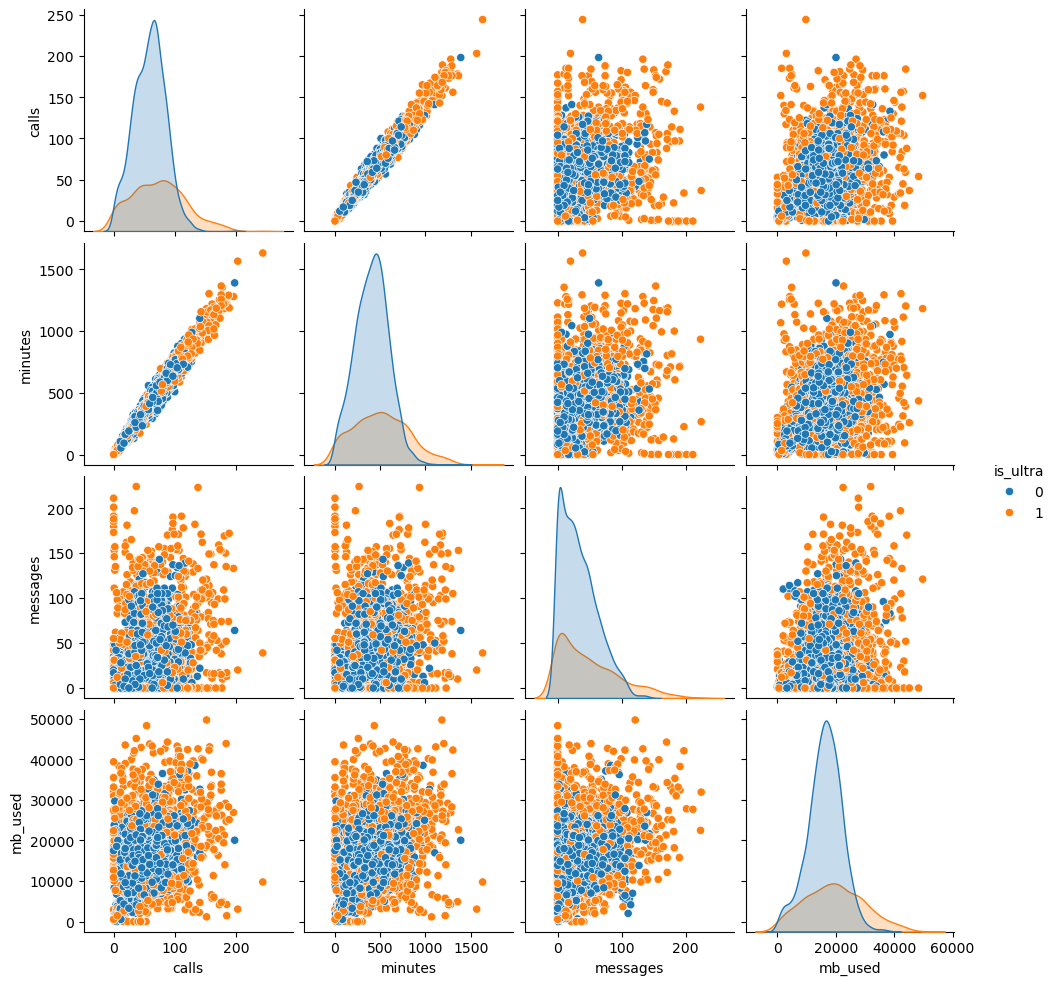

In [10]:
sns.pairplot(df, hue='is_ultra')

## Разбейте данные на выборки

In [12]:
# разобъём данные на три выборки в пропорции 60:20:20:
df_train, df_test_1 = train_test_split(df, test_size=0.4, random_state=12345)
df_test, df_val = train_test_split(df_test_1, test_size=0.5, random_state=12345)

## Исследуйте модели

In [15]:
# создаём переменные для признаков и целевого признака
features_train = df_train.drop(columns=['is_ultra'])
target_train = df_train.is_ultra
features_val = df_val.drop(columns=['is_ultra'])
target_val = df_val.is_ultra
features_test = df_test.drop(columns=['is_ultra'])
target_test = df_test.is_ultra

# Выведем на экран размеры таблиц
print(features_train.shape)
print(target_train.shape)
print(features_val.shape)
print(target_val.shape)
print(features_test.shape)
print(target_test.shape)

(1928, 4)
(1928,)
(643, 4)
(643,)
(643, 4)
(643,)


Выбираем самую "правильную" в теории модель "случайный лес":

In [17]:
# обучим с заданным количеством деревьев:
best_model = None
best_result = 0
for est in range(10, 50):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_train, target_train)
    # посчитаем качество модели на валидационной выборке
    result = model.score(features_val, target_val)
    if result > best_result:
        best_model = model
        best_result =  result
        
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print(best_model)

Accuracy наилучшей модели на валидационной выборке: 0.7962674961119751
RandomForestClassifier(n_estimators=48, random_state=12345)


In [21]:
# Обучим модель с лучшим параметром:
model = RandomForestClassifier(random_state=12345, n_estimators=48)
model.fit(features_train, target_train)

RandomForestClassifier(n_estimators=48, random_state=12345)

In [22]:
# добавим лучший max_depth из цикла для дерева решений ниже:
model = RandomForestClassifier(random_state=12345, n_estimators=48, max_depth=7)
model.fit(features_train, target_train)
model.score(features_val, target_val)

0.8009331259720062

Показатель правильности относительно высокий, но попробуем ещё один алгоритм — логистическую регрессию:

In [24]:
model_2 = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model_2.fit(features_train, target_train)
print("Accuracy модели логистической регрессии на валидационной выборке:",
      model_2.score(features_val, target_val)) 

Accuracy модели логистической регрессии на валидационной выборке: 0.7387247278382582


Также проверим результат самого простого алгоритма - дерева решений:

In [26]:
# < сделаем цикл для max_depth от 1 до 5 >
for depth in range(1,11):
    model_3 = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_3.fit(features_train, target_train)
    
    print("max_depth =", depth, ": ", end='')
    print(model_3.score(features_val, target_val)) 

max_depth = 1 : 0.7356143079315708
max_depth = 2 : 0.7744945567651633
max_depth = 3 : 0.7791601866251944
max_depth = 4 : 0.7744945567651633
max_depth = 5 : 0.7838258164852255
max_depth = 6 : 0.776049766718507
max_depth = 7 : 0.7993779160186625
max_depth = 8 : 0.7931570762052877
max_depth = 9 : 0.7807153965785381
max_depth = 10 : 0.7884914463452566


Вывод: В ходе исследования были построены три модели на разных алгоритмах для решений задачи классификации, которая выберет подходящий тариф. Проверены метрики "правильности" каждой из них и выявлена лучшая. Модель на основании алгоритма "случайный лес" выберет подходящий тариф для пользователей с вероятностью 80%.

## Проверьте модель на тестовой выборке

In [30]:
print("Accuracy модели случайного леса на тестовой выборке:",
      model.score(features_test, target_test))

Accuracy модели случайного леса на тестовой выборке: 0.80248833592535


Модель способна ли она давать хорошие предсказания на данных, которые она никогда не видела. Результаты на тесте и валидации схожи, это говорит о том, что модель хорошо обучена и не переобучена на валидационной выборке.

## (бонус) Проверьте модели на адекватность

С метрикой 0.8 модель сильно превосходит случайную модель с 0.5.
Сравним метрику качества полученной модели с примитивной моделью, когда всем клиентам самый популярный тариф. 

In [35]:
ultra = df[df['is_ultra'] == 1]['is_ultra'].count()
smart = df[df['is_ultra'] == 0]['is_ultra'].count()
print("Число клиентов с тарифом Ультра:", ultra)
print("Число клиентов с тарифом Смарт:", smart)

Число клиентов с тарифом Ультра: 985
Число клиентов с тарифом Смарт: 2229


In [36]:
# Сравним метрику accuracy с нашей моделью:
accuracy = df[df['is_ultra'] == 0]['is_ultra'].count() / df['is_ultra'].count()
print("Accuracy примитивной модели:", accuracy)
print("Accuracy модели случайного леса на тестовой выборке:",
      model.score(features_test, target_test))

Accuracy примитивной модели: 0.693528313627878
Accuracy модели случайного леса на тестовой выборке: 0.80248833592535


In [38]:
# базовая модель с готовым алгоритмом
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
dummy_clf.score(features_test, target_test)

0.7060653188180405

Модель проходит данную проверку на адекватность.